[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HSinger04/DL4NLP/blob/master/src/assignment2.ipynb#scrollTo=ieu7mWKsqGg6)

# Bag of Words Text Classification

In this assignment we will build a simple Bag of Words (BoW) text classifier using PyTorch. The classifier is trained on Twitter Sentiment dataset and is supposed to identify if the Sentiment is positive or negative.


## Concepts covered in this assignment
1. NLP text pre-processing
2. Split of training, validation and testing datasets
3. Build a simple feed-forward neural net classifier using PyTorch 
4. Training the model 



As always we start with some imports!




In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import random
import re # regular expression
from collections import Counter 
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import google_drive_downloader
from google_drive_downloader import GoogleDriveDownloader as gdd
from IPython.core.display import display, HTML
from sklearn.metrics import classification_report
from tqdm import tqdm, tqdm_notebook # show progress bar

# PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

# nltk text processors
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
plt.style.use('ggplot')
tqdm.pandas()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
DATA_PATH = 'data/twitter_reviews.csv'
if not Path(DATA_PATH).is_file():
    gdd.download_file_from_google_drive(
        file_id='13OLqDXOBAO9fjD9Shz8iTeev3ZaNHaTC',
        dest_path=DATA_PATH,
    )

**Take a look at a few examples**

Here is a sample set of five random tweets, we are classifying in positive (label = 1) and negative tweets (label = 0).


In [ ]:
df = pd.read_csv(DATA_PATH)
df.sample(5)

,Unnamed: 0,tweet,label
894387,894387,@jolenejaye I believe in you! And coffee!,1
80329,80329,@ArtEnvironments added gmail was a perfect al...,1
597456,597456,@AnnaLynneMc your car is one of my favorites! ...,1
68171,68171,@booshtukka Stop eating cheese before going to...,1
849144,849144,@Inluu Really? Wow.. That's high!,1


In [ ]:
print('Number of records:', len(df), '\n')
print('Number of positive tweets:', len(df[df.label == 1]))
print('Number of negative tweets:', len(df[df.label == 0]), '\n')

print('Example negative tweet:')
print(df.loc[55,].tweet, '\n')
print('Example positive tweet:')
print(df.loc[12456,].tweet, '\n')

Number of records: 1000000 

Number of positive tweets: 531354
Number of negative tweets: 468646 

Example negative tweet:
  David must be hospitalized for five days end of July (palatine tonsils). I will probably never see Katie in concert.  

Example positive tweet:
*sigh*  sweet dreams guys...... 



# 1. Preprocess Text

* Replace weird characters
* Lowercase
* Tokenize 
* Stemming & Lemmatize
* Remove stopwords

**Let's see how to pre-process these steps one by one. Below we constructed a test corpus which is composed of 3 reviews. Each review is a paragraph.**

In [ ]:
test_corpus = '''Curtain drops at the #Crown Uptown after 32 years http://www.kansas.com/news/featured/story/860875.html
'''
test_corpus

'Curtain drops at the #Crown Uptown after 32 years http://www.kansas.com/news/featured/story/860875.html\n'

<h1>Execercise 1.1</h1> (1 Points)<br>


Write a function "special_and_lower" that removes special characters and put the text lowercase. If you wonder what a special character is, check [here](https://www.computerhope.com/jargon/s/specchar.htm#:~:text=A%20special%20character%20is%20a,characters%20may%20have%20multiple%20uses.): 


In [ ]:
# remove special characters & lowercase
def special_and_lower(text):

  text = re.findall(r'\w+', text, re.ASCII)
  
  no_special = ""

  for word in text[:-1]:
    no_special += word + " "  

  # don't add trailing space for last word  
  no_special += text[-1]

  # lower
  text = no_special.lower()

  return text

test_corpus = special_and_lower(test_corpus)
print(test_corpus)

curtain drops at the crown uptown after 32 years http www kansas com news featured story 860875 html


<h1>Execercise 1.2</h1> (1 Points)<br> Write a function "tokenize_text" that tokenizes the text.

In [ ]:
# tokenize
def tokenize_text(text):

  try:
    text = nltk.word_tokenize(text)
  except: 
    nltk.download("punkt")
    text = nltk.word_tokenize(text)
  

  return text

test_corpus = tokenize_text(test_corpus)
print(test_corpus)

['curtain', 'drops', 'at', 'the', 'crown', 'uptown', 'after', '32', 'years', 'http', 'www', 'kansas', 'com', 'news', 'featured', 'story', '860875', 'html']


<h1>Execercise 1.3</h1> (1 Points) <br> 


Using *WordNetLemmatizer*, write a function "lemmatize_text" that lemmatizes the text. Lemmatization, which is the process of grouping inflected forms together as a single base form, is a text normalization that is used in pre-processing. Please lemmatize first nouns and then verbs. For more information regarding *WordNetLemmatizer*, please check [here](https://www.nltk.org/_modules/nltk/stem/wordnet.html): 


In [ ]:
from nltk.corpus.reader import wordnet

# lemmatize
def lemmatize_text(text, wnl):

  for i, word in enumerate(text):
    # lemmatize noun
    lemma = wnl.lemmatize(word)
    # lemmatize verb
    lemma = wnl.lemmatize(word, pos=wordnet.VERB)
    text[i] = lemma

  return text

test_corpus = lemmatize_text(test_corpus, WordNetLemmatizer())
print(test_corpus)

['curtain', 'drop', 'at', 'the', 'crown', 'uptown', 'after', '32', 'years', 'http', 'www', 'kansas', 'com', 'news', 'feature', 'story', '860875', 'html']


<h1>Execercise 1.4 </h1>(1 Points) <br>Write a function "replace_numbers" that replaces any standalone number with the special token '<NUM>'. For instance, '42' must be replaced by the token but '42h' not.




In [ ]:
# replace numbers
def replace_numbers(text):

  for i, lemma in enumerate(text):
    text[i] = re.sub(r"[0-9]+", "<NUM>", lemma)

  return text

test_corpus = replace_numbers(test_corpus)
print(test_corpus)

['curtain', 'drop', 'at', 'the', 'crown', 'uptown', 'after', '<NUM>', 'years', 'http', 'www', 'kansas', 'com', 'news', 'feature', 'story', '<NUM>', 'html']


<h1>Execercise 1.5</h1> (1 Points)<br> We want to remove words that are very common in all the texts (like "a" or "to"). These words are called stopwords and do not contain any meaning, that is relevant for our task. 
Write a function "remove_stopwords" that removes stopwords using the stopwords imported from NLTK (check on top).

In [ ]:
# remove stopwords
def remove_stopwords(text, stop_words):

  for i, word in enumerate(text):
    if word in stop_words:
      text.pop(i)

  return text

stop_words = set(stopwords.words('english'))
remove_stopwords(test_corpus, stop_words)

['curtain',
 'drop',
 'the',
 'crown',
 'uptown',
 '<NUM>',
 'years',
 'http',
 'www',
 'kansas',
 'com',
 'news',
 'feature',
 'story',
 '<NUM>',
 'html']

# 2. Building the Vocabulary

<h1>Execercise 2.1</h1> (2 Points)<br> Define the function `build_vocab` which receives as input `clean_tokens` and returns `vocab`, which is a python dictionary with words as keys and unique integer indexes as values. 



In [ ]:
def build_vocab(corpus):
  vocab = {}
  i = 0

  for tokens in corpus:
    for token in tokens:
      if not token in vocab:
        vocab[token] = i
        i += 1  

  return vocab
print(build_vocab([test_corpus]))

{'curtain': 0, 'drop': 1, 'the': 2, 'crown': 3, 'uptown': 4, '<NUM>': 5, 'years': 6, 'http': 7, 'www': 8, 'kansas': 9, 'com': 10, 'news': 11, 'feature': 12, 'story': 13, 'html': 14}


<h1>Execercise 2.2 </h1>(2 Points)<br> Define the function `build_index2token` which receives as input `vocab` (the output of the previously defined function `build_vocab`) and returns `index2token`, which is a python dictionary with unique integer indexes as keys and  words as values. Make sure that the indexes assigned to the words are exactly the same as in `vocab`.


In [ ]:
def build_index2token(vocab):

    index2token = dict((v,k) for k,v in vocab.items())

    return index2token

print(build_index2token(build_vocab([test_corpus]))) 

{0: 'curtain', 1: 'drop', 2: 'the', 3: 'crown', 4: 'uptown', 5: '<NUM>', 6: 'years', 7: 'http', 8: 'www', 9: 'kansas', 10: 'com', 11: 'news', 12: 'feature', 13: 'story', 14: 'html'}


**Let's pacakage the pre-processing steps together into functions and apply on our dataset**



In [ ]:
def remove_rare_words(tokens, common_tokens, max_len):
    return [token if token in common_tokens else '<UNK>' for token in tokens][-max_len:]

def tokenize(text, stop_words, lemmatizer):
    # remove special characters and put text lowercase
    text = special_and_lower(text)

    # tokenize
    tokens = tokenize_text(text) 

    # lemmatize nouns and verbs
    tokens = lemmatize_text(tokens, lemmatizer)

    # remove stopwords
    tokens = remove_stopwords(tokens, stop_words)

    return tokens

def build_bow_vector(sequence, idx2token):
    vector = [0] * len(idx2token)
    for token_idx in sequence:
        if token_idx not in idx2token:
            raise ValueError('Wrong sequence index found!')
        else:
            vector[token_idx] += 1
    return vector

# 3. Splitting and transforming the Dataset

<h1>Execercise 3.1</h1> (not scored) <br>
 Play with `MAX_LEN` and `MAX_VOCAB` parameters. Try to find which parameter configuration leads to better classification performance. 

In [ ]:
# Set parameters
# TODO: just used MAX_LEN = 16 for quick check

MAX_LEN = "128" #@param [16, 32, 64, 128, 256, 512] {allow-input: true}
MAX_VOCAB = "100" #@param [100, 1000, 5000, 10000, 100000] {allow-input: true}

MAX_LEN = int(MAX_LEN)
MAX_VOCAB = int(MAX_VOCAB)

Next we will build our class TwitterDataset. It helps us to easier access different parts of our DataSet.

In [ ]:
class TwitterDataset(Dataset):
    def __init__(self, data_path, max_vocab=5000, max_len=128):
        df = pd.read_csv(data_path)
        
        # Clean and tokenize
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
        df['tokens'] = df.tweet.apply(
            partial(
                tokenize,
                stop_words=stop_words,
                lemmatizer=lemmatizer,
            ),
        )  
        
        all_tokens = [token for doc in list(df.tokens) for token in doc]
        
        # Build most common tokens bound by max vocab size
        common_tokens = set( 
            list(
                zip(*Counter(all_tokens).most_common(max_vocab))
            )[0] 
        )
        
        # Replace rare words with <UNK>
        
        df.loc[:, 'tokens'] = df.tokens.progress_apply(
            partial(
                remove_rare_words,
                common_tokens=common_tokens,
                max_len=max_len,
            ),
        )
        
        # Replace numbers with <NUM>
        df.loc[:, 'tokens'] = df.tokens.progress_apply(replace_numbers)
        
        # Remove sequences with only <UNK>
        df = df[df.tokens.progress_apply(
            lambda tokens: any(token != '<UNK>' for token in tokens),
        )]
        
        # Build vocab
        self.token2idx = build_vocab(list(df.tokens))
        self.idx2token = build_index2token(self.token2idx)
        # vocab = sorted(set(
        #     token for doc in list(df.tokens) for token in doc
        # ))
        # self.token2idx = {token: idx for idx, token in enumerate(vocab)}
        # self.idx2token = {idx: token for token, idx in self.token2idx.items()}
        
        # Convert tokens to indexes
        df['indexed_tokens'] = df.tokens.progress_apply(
            lambda doc: [self.token2idx[token] for token in doc],
        )
        
        # Build BoW vector
        df['bow_vector'] = df.indexed_tokens.progress_apply(
            build_bow_vector, args=(self.idx2token,)
        )
        
        self.text = df.tweet.tolist()
        self.sequences = df.indexed_tokens.tolist()
        self.bow_vector = df.bow_vector.tolist()
        self.targets = df.label.tolist()
    
    def __getitem__(self, i):
        return (
            self.sequences[i],
            self.bow_vector[i],
            self.targets[i],
            self.text[i],
        )
    
    def __len__(self):
        return len(self.targets)

In [ ]:
#This will load for a while: Grab a coffee
dataset = TwitterDataset(DATA_PATH, max_vocab=MAX_VOCAB, max_len=MAX_LEN)

100%|██████████| 921616/921616 [00:05<00:00, 168394.02it/s]


See a random sample out of the dataset processed

In [ ]:
print('Number of records:', len(dataset), '\n')

import random
random_idx = random.randint(0,len(dataset)-1)
print('index:', random_idx, '\n')
sample_seq, bow_vector, sample_target, sample_text = dataset[random_idx]
print(sample_text, '\n')
print(sample_seq, '\n')
print('BoW vector size:', len(bow_vector), '\n')
print('label:', sample_target, '\n')

Number of records: 921616 

index: 122661 

@DoubleFresh Totally! I'm finding myself strangely attracted to chrome trashcans and a delightful array of drinks.  

[3, 3, 24, 73, 3, 3, 3, 3, 33, 3, 3, 3] 

BoW vector size: 100 

label: 1 



<h1>Execercise 3.2</h1> (2 Points)<br> Split into training, validation, and test sets. 

Since we only have a certain ammount of Data to train, validate and test our model on, we need to split our Dataset into 3 Parts:

- **Training**: data the model learns from (80%)
- **Validation**: data to evaluate with for hyperparameter tuning (make sure the model doesn't overfit!) (10%)
- **Testing**: data to evaluate the final performance of the model (10%)

Given the ratios for validation and testing, it is your task to complete the `function split_train_valid_test` and calculate the three split lenghts, which are then used as argument in the `random_split` function we have imported at the top of this notebook.

In [ ]:
def split_train_valid_test(corpus, valid_ratio=0.1, test_ratio=0.1):
    """Split dataset into train, validation, and test."""
    corpus_length = len(corpus)
    test_length = int((1 - valid_ratio - test_ratio)  * corpus_length)
    valid_length = int((corpus_length - test_length) / 2)
    # take whatever remains for train_length, which is roughly equivalent to valid_length
    train_length = corpus_length - test_length - valid_length
    return random_split(
        corpus, lengths=[train_length, valid_length, test_length],
    )

In [ ]:
#Now we apply the function above:
train_dataset, valid_dataset, test_dataset = split_train_valid_test(
    dataset, valid_ratio=0.05, test_ratio=0.05)
len(train_dataset), len(valid_dataset), len(test_dataset)

(46081, 46081, 829454)

Next up: Batching. Since our Neural Network can only Work on a certain amount of Data at one point in time and we dont have endless amounts of RAM at our hands we will use Batching and Split our Data-Set into Mouth-sized bites.

In [ ]:
BATCH_SIZE = 528

def collate(batch):
    seq = [item[0] for item in batch]
    bow = [item[1] for item in batch]
    target = torch.LongTensor([item[2] for item in batch])
    text = [item[3] for item in batch]
    return seq, bow, target, text

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate)

After splitting our Data it now looks like this:

In [ ]:
print('number of training batches:', len(train_loader), '\n')
batch_idx = random.randint(0, len(train_loader)-1)
example_idx = random.randint(0, BATCH_SIZE-1)

for i, fields in enumerate(train_loader):
    seq, bow, target, text = fields
    if i == batch_idx:
        print('Training input sequence:', seq[example_idx], '\n')
        print('BoW vector size:', len(bow[example_idx]), '\n')
        print('Label: ', target[example_idx], '\n')
        print('Review text:', text[example_idx], '\n')
    

number of training batches: 88 

Training input sequence: [3, 45, 46, 3] 

BoW vector size: 100 

Label:  tensor(0) 

Review text: @englandsimpson I wish I could be there  



# 4. BoW Model

### Build BoW Model

![BOW](https://github.com/scoutbeedev/pytorch-nlp-notebooks/blob/master/images/bow_representation.png?raw=1)

In the cell below 4.1 we implemented a BoW-Model with the following specifics:
- Input: BoW Vector
- Model: 
    - feed-forward fully connected network
    - 2 hidden layers
- Output: 
    - vector size of 2 (2 possible outcome: positive v.s. negative)
    - probability of input document classified as the label

<h1>Execercise 4.1 </h1> (2 Points)<br> 

Substitute the two non-linear functions which are currently of type `relu` with any other type you like. You may want to experiment with several types and then leave you favourite in the final solution. Check [here](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) for the available non-linear functions in Pytorch.

In [ ]:
class FeedfowardTextClassifier(nn.Module):
    def __init__(self, device, vocab_size, hidden1, hidden2, hidden3, num_labels, batch_size):
        super(FeedfowardTextClassifier, self).__init__()
        self.device = device
        self.batch_size = batch_size
        #Here we have the different Layers of our NN
        self.fc1 = nn.Linear(vocab_size, hidden1) 
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.fc4 = nn.Linear(hidden3, num_labels)
    
    def forward(self, x):
        batch_size = len(x)
        if batch_size != self.batch_size:
            self.batch_size = batch_size
            
        #Now we feed our Data through our NN
        x = torch.FloatTensor(x)
        x = F.elu(self.fc1(x)) 
        x = F.leaky_relu(self.fc2(x)) 
        x = F.relu(self.fc3(x))
        return torch.sigmoid(self.fc4(x))


<h1>Execercise 4.2</h1>
(not scored)<br> Play with HIDDEN1 and HIDDEN2 parameters. Try to find which parameter configuration leads to better classification performance. The number below influences the amount of Neurons per Layer.

In [ ]:
# Define hidden layer size
HIDDEN1 = "30" #@param [10, 30, 50, 100, 200, 500] {allow-input: true}
HIDDEN2 = 50 #@param [10, 30, 50, 100, 200, 500] {allow-input: true}
HIDDEN3 = 50 #@param [10, 30, 50, 100, 200, 500] {allow-input: true}

HIDDEN1 = int(HIDDEN1)
HIDDEN2 = int(HIDDEN2)
HIDDEN3 = int(HIDDEN3)

<h1>Execercise 4.3</h1> (2 Points) <br> Add a an extra hidden layer to the network, with a size of your choice. You can do it by modifying the cell below and of course adjusting the Class definition of `FeedfowardTextClassifier` such that it accepts one more layer when initialized.

In [ ]:
#initializing the model
bow_model = FeedfowardTextClassifier(
    vocab_size=len(dataset.token2idx),
    hidden1=HIDDEN1,
    hidden2=HIDDEN2,
    hidden3=HIDDEN3,
    num_labels=2,
    device=device,
    batch_size=BATCH_SIZE,
)
bow_model

FeedfowardTextClassifier(
  (fc1): Linear(in_features=100, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=2, bias=True)
)

In [ ]:
for param in bow_model.parameters():
    print(param.size())

torch.Size([30, 100])
torch.Size([30])
torch.Size([50, 30])
torch.Size([50])
torch.Size([50, 50])
torch.Size([50])
torch.Size([2, 50])
torch.Size([2])


### Train BoW Model




Layer 1 affine: $$x_1 = W_1 X + b_1$$
Layer 1 activation: $$h_1 = Relu(x_1)$$
Layer 2 affine: $$x_2 = W_2 h_1 + b_2$$
output: $$p = softmax(x_2)$$
Loss: $$L = −(ylog(p)+(1−y)log(1−p))$$
Gradient: 
$$\frac{\partial }{\partial W_1}L(W_1, b_1, W_2, b_2) = \frac{\partial L}{\partial p}\frac{\partial p}{\partial x_2}\frac{\partial x_2}{\partial h_1}\frac{\partial h_1}{\partial x_1}\frac{\partial x_1}{\partial W_1}$$

Parameter update:
$$W_1 = W_1 - \alpha \frac{\partial L}{\partial W_1}$$

<h1>Execercise 4.4</h1> (not scored)<br> What happens if you set a very small learning rate? What if you set a very large learning rate? 

In [ ]:
LEARNING_RATE = 1e-5

**Define loss function and gradient descent optimizer**

- Criterion: compute *Loss* to see how much the prediction does differ from truth
- Optimizer: different ways of updating the weight parameters. It can affect the speed of training and how easily the global minimum is reached. 
- scheduler: dynamic alteration of the learning rate

When selecting optimizers, you can think about what problems can we run into when performing gradient desent? (hint: global minimum v.s. local minimum)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, bow_model.parameters()),
    lr=LEARNING_RATE,
)
scheduler = CosineAnnealingLR(optimizer, 1)

**Define training round & validation round**

In [ ]:
def train_epoch(model, optimizer, train_loader, input_type='bow'):
    model.train()
    total_loss, total = 0, 0
    for seq, bow, target, text in train_loader:
        if input_type == 'bow':
            inputs = bow
        
        # Reset gradient
        optimizer.zero_grad()
        
        # Forward pass
        output = model(inputs)
        
        # Compute loss
        loss = criterion(output, target)
        
        # Perform gradient descent, backwards pass
        loss.backward()

        # Take a step in the right direction
        optimizer.step()
        scheduler.step()

        # Record metrics
        total_loss += loss.item()
        total += len(target)

    return total_loss / total


def validate_epoch(model, valid_loader, input_type='bow'):
    model.eval()
    total_loss, total = 0, 0
    with torch.no_grad():
        for seq, bow, target, text in valid_loader:
            if input_type == 'bow':
                inputs = bow

            # Forward pass
            output = model(inputs)

            # Calculate how wrong the model is
            loss = criterion(output, target)

            # Record metrics
            total_loss += loss.item()
            total += len(target)

    return total_loss / total

** Run training epochs**

In [ ]:
n_epochs = 0
max_epochs =50
train_losses, valid_losses = [], []
while n_epochs <= max_epochs:
    train_loss = train_epoch(bow_model, optimizer, train_loader, input_type='bow')
    valid_loss = validate_epoch(bow_model, valid_loader, input_type='bow')
    
    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}\tvalid_loss: {valid_loss:.2e}\n',
    )
    
    # Early stopping if the current valid_loss is greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss >= loss for loss in valid_losses[-3:]):
        print('Stopping early')
        break
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    n_epochs += 1

epoch #  1	train_loss: 1.33e-03	valid_loss: 1.33e-03

epoch #  2	train_loss: 1.33e-03	valid_loss: 1.33e-03

epoch #  3	train_loss: 1.33e-03	valid_loss: 1.33e-03

epoch #  4	train_loss: 1.33e-03	valid_loss: 1.33e-03

epoch #  5	train_loss: 1.33e-03	valid_loss: 1.33e-03

epoch #  6	train_loss: 1.33e-03	valid_loss: 1.33e-03

epoch #  7	train_loss: 1.32e-03	valid_loss: 1.33e-03

epoch #  8	train_loss: 1.32e-03	valid_loss: 1.32e-03

epoch #  9	train_loss: 1.32e-03	valid_loss: 1.32e-03

epoch # 10	train_loss: 1.32e-03	valid_loss: 1.32e-03

epoch # 11	train_loss: 1.32e-03	valid_loss: 1.32e-03

epoch # 12	train_loss: 1.32e-03	valid_loss: 1.32e-03

epoch # 13	train_loss: 1.32e-03	valid_loss: 1.32e-03

epoch # 14	train_loss: 1.32e-03	valid_loss: 1.32e-03

epoch # 15	train_loss: 1.32e-03	valid_loss: 1.32e-03

epoch # 16	train_loss: 1.32e-03	valid_loss: 1.32e-03

epoch # 17	train_loss: 1.32e-03	valid_loss: 1.32e-03

epoch # 18	train_loss: 1.32e-03	valid_loss: 1.32e-03

epoch # 19	train_loss: 1.32e

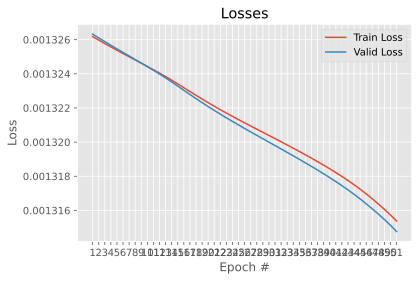

In [ ]:
epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses') 
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

# 5. Check Performance of BoW Model

<h1>Execercise 5.1</h1> (2 Points)<br> Calculate `precision`, `recall` and `f1-score` for each of the classes. Those are common measures to define the quality of our classifier. 

![](https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg)

In [148]:
bow_model.eval()
test_accuracy, n_examples = 0, 0
y_true, y_pred = [], [] #The two important Measures: What the tweet really is and what it was predicted to be.
input_type = 'bow'

with torch.no_grad():
    for seq, bow, target, text in test_loader:
        inputs = bow
        probs = bow_model(inputs)
        
        probs = probs.detach().cpu().numpy()
        predictions = np.argmax(probs, axis=1)
        target = target.cpu().numpy()
        
        y_true.extend(target)
        y_pred.extend(predictions)

tp = 0
fp = 0
fn = 0

# get total numbers of true positives, false positives and false negatives
for (true, pred) in zip(y_true, y_pred):
  if true == pred and true == 1:
    tp += 1
  elif not true == pred:
    if pred == 0:
      fn += 1
    else:
      fp += 1  

precision = tp / (tp + fp)        
recall = tp / (tp + fn)
f1_score = (2 * precision * recall) / (precision + recall)

print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F1-Score: " + str(f1_score))
print("Accuracy: " + str(np.mean(np.array(y_true) == np.array(y_pred))))

Precision: 0.5327453677284677
Recall: 0.9965081059382727
F1-Score: 0.6943061912026444
Accuracy: 0.5361599317141156


**Let's check a few examples**

Checking them might help us, to understand, what is still going wrong.

In [ ]:
flatten = lambda x: [sublst for lst in x for sublst in lst]
seq_lst, bow_lst, target_lst, text_lst = zip(*test_loader)
seq_lst, bow_lst, target_lst, text_lst = map(flatten, [seq_lst, bow_lst, target_lst, text_lst])
test_examples = list(zip(seq_lst, bow_lst, target_lst, text_lst))

def print_random_prediction(model, n=4, input_type='bow'):
    # prints prediction made by the model and the true value for n items. 
    to_emoji = lambda x: '😄' if x else '😡'
    model.eval()
    rows = []
    for i in range(n):
        with torch.no_grad():
            seq, bow, target, text = random.choice(test_examples)
            target = target.item()
            
            inputs = bow
            probs = model([inputs])
            probs = probs.detach().cpu().numpy()
            prediction = np.argmax(probs, axis=1)[0]

            predicted = to_emoji(prediction)
            actual = to_emoji(target)
            
            row = f"""
            <tr>
            <td>{i+1}&nbsp;</td>
            <td>{text}&nbsp;</td>
            <td>{predicted}&nbsp;</td>
            <td>{actual}&nbsp;</td>
            </tr>
            """
            rows.append(row)
            
    rows_joined = '\n'.join(rows)
    table = f"""
    <table>
    <tbody>
    <tr>
    <td><b>Number</b>&nbsp;</td>
    <td><b>Review</b>&nbsp;</td>
    <td><b>Predicted</b>&nbsp;</td>
    <td><b>Actual</b>&nbsp;</td>
    </tr>{rows_joined}
    </tbody>
    </table>
    """
    display(HTML(table))

In [ ]:
print_random_prediction(bow_model, n=4, input_type='bow')

Number,Review,Predicted,Actual
1,@alexrpm watch it on ITV player. I don't have a TV so can't watch it live either BBC iPlayer ftw,😄,😡
2,"@Anitta_ yes, I have tuenti searh ""ieves Herrero"" school, ""juana I de Castilla"" and this Iï¿½m",😄,😄
3,@bluejava Ooh! Those things are a good enough excuse for anything overlooked!,😄,😄
4,@MadFreshDaily no ma'am. Got a little tired Have some tom during the day. WestCoast rappers bbq so you alllllready know. Clown time,😄,😡
5,@fallbrooke i need s0me cheering up guys i l0ve u,😄,😡
6,"@KaarinE Shortage of DPS or shortage of knowing left from right? Either way, that sucks",😄,😡
7,"@stonernation thanks guys. I don't know what happened I followed everyone who flwd me yesterday. And no, I didn't clean up did that b4.",😄,😡
8,check www.audioinfected.com - es gibt ein neues mp3,😄,😄
9,@wellyjulz haha thats true. It's all about style! Style = brace the cold,😄,😄
10,@Teeravioli very true haha @Wardere wait...it was for Fred? haha wow youtube,😄,😄


You are done, CONGRATS!!!
